In [16]:
# Check inside the color directory
import os
color_path = '/content/plantvillage/plantvillage dataset/color'
print("Contents of color directory:")
folders = [d for d in os.listdir(color_path) if os.path.isdir(os.path.join(color_path, d))]
print(f"Found {len(folders)} disease class folders:")
for f in folders[:10]:
    print(f"  - {f}")
if len(folders) > 10:
    print(f"  ... and {len(folders)-10} more")

Contents of color directory:
Found 38 disease class folders:
  - Pepper,_bell___Bacterial_spot
  - Tomato___Leaf_Mold
  - Blueberry___healthy
  - Tomato___Spider_mites Two-spotted_spider_mite
  - Tomato___Late_blight
  - Cherry_(including_sour)___Powdery_mildew
  - Pepper,_bell___healthy
  - Grape___Esca_(Black_Measles)
  - Corn_(maize)___healthy
  - Strawberry___Leaf_scorch
  ... and 28 more


# Plant Disease Classification and Crop Recommendation System

This notebook implements two machine learning systems:
1. **Plant Disease Classification**: Uses CNN for image-based disease detection
2. **Crop Recommendation System**: Uses ML algorithms for crop prediction based on soil and climate data

In [1]:
# Install required libraries
!pip install kaggle -q
!pip install tensorflow -q
!pip install scikit-learn -q
!pip install matplotlib seaborn -q

## Part 1: Plant Disease Classification using CNN

### Setup and Data Loading

In [2]:
# Kaggle API Authentication
import os
from google.colab import files

# Upload kaggle.json
print("Upload kaggle.json:")
uploaded = files.upload()

# Setup Kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
print("Kaggle authentication successful!")

Upload kaggle.json:


Saving kaggle.json to kaggle.json
Kaggle authentication successful!


In [3]:
# Download Plant Disease Dataset from Kaggle
# Example: PlantVillage Dataset
!kaggle datasets download -d abdallahalidev/plantvillage-dataset
!unzip -q plantvillage-dataset.zip -d /content/plantvillage
print("Plant disease dataset downloaded and extracted!")

Dataset URL: https://www.kaggle.com/datasets/abdallahalidev/plantvillage-dataset
License(s): CC-BY-NC-SA-4.0
 98% 2.00G/2.04G [00:16<00:00, 214MB/s]
100% 2.04G/2.04G [00:16<00:00, 132MB/s]
Plant disease dataset downloaded and extracted!


In [4]:
# Import necessary libraries for CNN
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import matplotlib.pyplot as plt
import numpy as np
import os

print("Libraries imported successfully!")

Libraries imported successfully!


In [13]:
# Data Preprocessing and Augmentation - FIXED PATH
# ISSUE: The disease class folders are inside '/content/plantvillage/plantvillage dataset/color/'
# NOT at '/content/plantvillage' level
data_dir = '/content/plantvillage/plantvillage dataset/color'
img_size = 128
batch_size = 32

# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2
)

# Load training data
train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

# Load validation data
val_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

num_classes = len(train_generator.class_indices)
print(f"Number of classes: {num_classes}")
print(f"Class examples: {list(train_generator.class_indices.keys())[:5]}...")  # Show first 5

Found 43456 images belonging to 38 classes.
Found 10849 images belonging to 38 classes.
Number of classes: 38
Class examples: ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy']...


In [17]:
# Build CNN Model with correct num_classes
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(img_size, img_size, 3)),
    MaxPooling2D(2, 2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')  # Uses num_classes from data generators
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("CNN Model built and compiled successfully!")
model.summary()

CNN Model built and compiled successfully!


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 38)             │         9,766 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,525,798 (24.89 MB)

 Trainable params: 6,525,798 (24.89 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
# Train the CNN Model
epochs = 10

history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=val_generator
)

print("Training completed!")

Epoch 1/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 296s 215ms/step - accuracy: 0.3553 - loss: 2.4031 - val_accuracy: 0.7144 - val_loss: 0.9334
Epoch 2/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 286s 211ms/step - accuracy: 0.6638 - loss: 1.1170 - val_accuracy: 0.7977 - val_loss: 0.6550
Epoch 3/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 271s 199ms/step - accuracy: 0.7484 - loss: 0.8141 - val_accuracy: 0.8428 - val_loss: 0.5084
Epoch 4/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 271s 200ms/step - accuracy: 0.7823 - loss: 0.6927 - val_accuracy: 0.8602 - val_loss: 0.4441
Epoch 5/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 264s 195ms/step - accuracy: 0.8101 - loss: 0.5979 - val_accuracy: 0.8795 - val_loss: 0.3771
Epoch 6/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 261s 192ms/step - accuracy: 0.8277 - loss: 0.5404 - val_accuracy: 0.8976 - val_loss: 0.3249
Epoch 7/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 255s 188ms/step - accuracy: 0.8464 - loss: 0.4934 - val_accuracy: 0.9132 - val_loss: 0.2836
Epoch 8/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 263s 193ms/step - ac

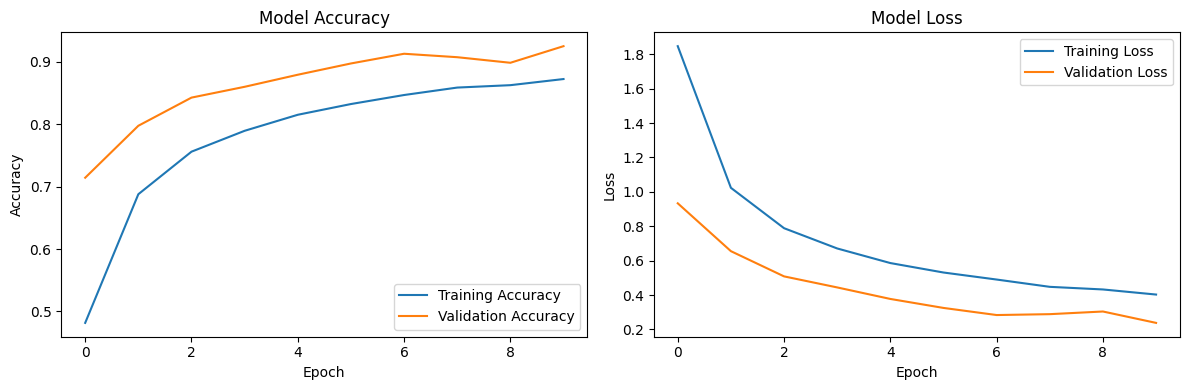

In [20]:
# Evaluate Model and Plot Training History
plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 725ms/step


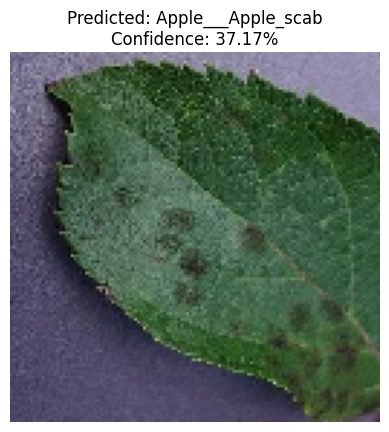

Predicted class: Apple___Apple_scab
Confidence: 37.17%


In [21]:
# Sample Prediction
from tensorflow.keras.preprocessing import image

# Get a sample image from validation set
class_names = list(train_generator.class_indices.keys())
sample_img_path = list(train_generator.filenames)[0]

img = image.load_img(os.path.join(data_dir, sample_img_path), target_size=(img_size, img_size))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) / 255.0

prediction = model.predict(img_array)
predicted_class = class_names[np.argmax(prediction)]
confidence = np.max(prediction) * 100

plt.imshow(img)
plt.title(f'Predicted: {predicted_class}\nConfidence: {confidence:.2f}%')
plt.axis('off')
plt.show()

print(f"Predicted class: {predicted_class}")
print(f"Confidence: {confidence:.2f}%")

In [22]:
# Save the Plant Disease Model
model.save('/content/plant_disease_model.h5')
print("Plant Disease Classification Model saved as 'plant_disease_model.h5'")

Plant Disease Classification Model saved as 'plant_disease_model.h5'


## Part 2: Crop Recommendation System

### Data Loading and Preprocessing

In [24]:
# Download Crop Recommendation Dataset
!kaggle datasets download -d atharvaingle/crop-recommendation-dataset
!unzip -q crop-recommendation-dataset.zip -d /content/

# Import libraries for ML
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pickle
import seaborn as sns

print("Libraries imported and dataset downloaded!")

Dataset URL: https://www.kaggle.com/datasets/atharvaingle/crop-recommendation-dataset
License(s): apache-2.0
crop-recommendation-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)
replace /content/Crop_recommendation.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
Libraries imported and dataset downloaded!


In [25]:
# Load and Explore Crop Recommendation Data
df = pd.read_csv('/content/Crop_recommendation.csv')

print("Dataset Shape:", df.shape)
print("\nFirst few rows:")
print(df.head())
print("\nDataset Info:")
print(df.info())
print("\nLabel distribution:")
print(df['label'].value_counts())

Dataset Shape: (2200, 8)

First few rows:
    N   P   K  temperature   humidity        ph    rainfall label
0  90  42  43    20.879744  82.002744  6.502985  202.935536  rice
1  85  58  41    21.770462  80.319644  7.038096  226.655537  rice
2  60  55  44    23.004459  82.320763  7.840207  263.964248  rice
3  74  35  40    26.491096  80.158363  6.980401  242.864034  rice
4  78  42  42    20.130175  81.604873  7.628473  262.717340  rice

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2200 entries, 0 to 2199
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   N            2200 non-null   int64  
 1   P            2200 non-null   int64  
 2   K            2200 non-null   int64  
 3   temperature  2200 non-null   float64
 4   humidity     2200 non-null   float64
 5   ph           2200 non-null   float64
 6   rainfall     2200 non-null   float64
 7   label        2200 non-null   object 
dtypes: float64(4), i

In [26]:
# Train Crop Recommendation Model
X = df.drop('label', axis=1)
y = df['label']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Evaluate
y_pred = rf_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Crop Recommendation Model Accuracy: {accuracy*100:.2f}%")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Crop Recommendation Model Accuracy: 99.32%

Classification Report:
              precision    recall  f1-score   support

       apple       1.00      1.00      1.00        23
      banana       1.00      1.00      1.00        21
   blackgram       1.00      1.00      1.00        20
    chickpea       1.00      1.00      1.00        26
     coconut       1.00      1.00      1.00        27
      coffee       1.00      1.00      1.00        17
      cotton       1.00      1.00      1.00        17
      grapes       1.00      1.00      1.00        14
        jute       0.92      1.00      0.96        23
 kidneybeans       1.00      1.00      1.00        20
      lentil       0.92      1.00      0.96        11
       maize       1.00      1.00      1.00        21
       mango       1.00      1.00      1.00        19
   mothbeans       1.00      0.96      0.98        24
    mungbean       1.00      1.00      1.00        19
   muskmelon       1.00      1.00      1.00        17
      orange  

In [27]:
# Sample Prediction for Crop Recommendation
sample_data = X_test.iloc[0:1]  # Get first test sample
predicted_crop = rf_model.predict(sample_data)[0]

print("Sample Input:")
print(sample_data)
print(f"\nRecommended Crop: {predicted_crop}")

Sample Input:
        N   P   K  temperature   humidity        ph   rainfall
1451  101  17  47    29.494014  94.729813  6.185053  26.308209

Recommended Crop: muskmelon


In [28]:
# Save Crop Recommendation Model
with open('/content/crop_recommendation_model.pkl', 'wb') as file:
    pickle.dump(rf_model, file)

print("Crop Recommendation Model saved as 'crop_recommendation_model.pkl'")
print("\n=== Both Models Successfully Trained and Saved ===")

Crop Recommendation Model saved as 'crop_recommendation_model.pkl'

=== Both Models Successfully Trained and Saved ===
